In [3]:
import sys
sys.path.append("../../utilities/")
import evaluation_utils
sys.path.append("../../src")
from dataset_class import dataset
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from hmmlearn import hmm

In [2]:
GM12878_signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
datasets = {}
for res in [10000, 25000, 100000]:
    
    datasets[res] = dataset('GM12878', 'hg19', res, '../../data/GM12878/hg19/Hi-C/GSE63525_GM12878_insitu_primary_30.hic',
                     '../../utilities/juicer_tools_1.22.01.jar', '../../data/GM12878/hg19/Hi-C/res{}'.format(res),
                     GM12878_signals_names, '../../data/GM12878/hg19/genomic-assays/bin_{}/'.format(res), 
                      '../../data/GM12878/hg19/res{}_datasets/'.format(res),
                      '../../data/', '../../utilities/config.json')
    datasets[res].load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/GM12878_{}_bins.txt'.format(res))

In [51]:
sizes = {}
valid_bins = {}
mats = {}
for res in [10000,25000,100000]:
    sizes[res] = datasets[res].get_chr_size(21)['chr_bin_num']
    valid_bins[res] = datasets[res].get_valid_bins(21)
    mats[res] = datasets[res].get_hic_mat(21,21,'oe')
    mats[res] = mats[res].toarray()[np.ix_(valid_bins[res],valid_bins[res])]
signals = {}
for res in [10000, 25000, 100000]:
    signals[res] = datasets[res].get_chrom_signals(21)

oe_chr21_chr21.txt does not exist
dumping oe_chr21_chr21.txt...
oe_chr21_chr21.txt does not exist
dumping oe_chr21_chr21.txt...


In [52]:
def diag_mat(original_size, shift):
    mat = np.zeros((original_size,original_size))
    for i in range(original_size-shift):
        mat[i,i+shift] = 1
        #mat[i+shift,i] = 1
    return mat

def diag_oe_mat(oe_mat, original_size, shift, valid_bins, weighted):
    dmat = diag_mat(original_size,shift)
    dmat = np.multiply(oe_mat>2,dmat[np.ix_(valid_bins,valid_bins)])
    if weighted:
        dmat = np.multiply(dmat, oe_mat)
    return dmat

def diag_fithic_mat(fithic_mat, original_size, shift, valid_bins):
    dmat = diag_mat(original_size,shift)
    dmat = np.multiply(fithic_mat,dmat[np.ix_(valid_bins,valid_bins)])
    return dmat

In [64]:
spatial_corrs = {}
significant_spatial_corrs = {}
for signal_id, signal_name in enumerate(GM12878_signals_names):
    for res in [10000,25000,100000]:
        print(signal_name, res)
        spatial_corrs[signal_name,res] = []
        significant_spatial_corrs[signal_name,res] = []
        for sh in np.arange(int(1000000/res)):
            dmat = diag_mat(sizes[res],sh)[np.ix_(valid_bins[res],valid_bins[res])]
            spatial_corr = evaluation_utils.spatial_correlation(signals[res].iloc[:,signal_id].values,dmat)['moran']
            dmat = diag_oe_mat(mats[res], sizes[res], sh, valid_bins[res], 0)
            significant_spatial_corr = evaluation_utils.spatial_correlation(signals[res].iloc[:,signal_id].values,dmat)['moran']
            spatial_corrs[signal_name,res].append(spatial_corr)
            significant_spatial_corrs[signal_name,res].append(significant_spatial_corr)

DNase 10000
DNase 25000
DNase 100000
H3K4me2 10000
H3K4me2 25000
H3K4me2 100000
H3K27ac 10000
H3K27ac 25000
H3K27ac 100000
H2A.Z 10000
H2A.Z 25000
H2A.Z 100000
H3K9me3 10000
H3K9me3 25000
H3K9me3 100000
H3K4me1 10000
H3K4me1 25000
H3K4me1 100000
H3K27me3 10000
H3K27me3 25000
H3K27me3 100000
H3K9ac 10000
H3K9ac 25000
H3K9ac 100000
H3K4me3 10000
H3K4me3 25000
H3K4me3 100000
H3K36me3 10000
H3K36me3 25000
H3K36me3 100000
H3K79me2 10000
H3K79me2 25000
H3K79me2 100000
H4K20me1 10000
H4K20me1 25000
H4K20me1 100000


In [74]:
np.var(signals[10000].iloc[:,0].values)

0.9798497837388687

In [75]:
np.var(signals[100000].iloc[:,0].values)

0.3522824524011661

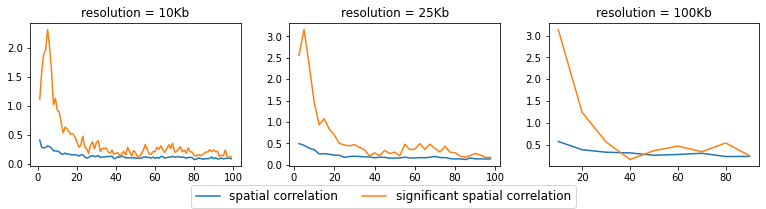

In [106]:
fig, axs = plt.subplots(1,3, figsize = (11,3))
sns.lineplot(x=np.arange(0,100)[1:], y=spatial_corrs['DNase',10000][1:], 
             label = 'spatial correlation', ax = axs[0])
sns.lineplot(x=np.arange(0,100)[1:], y=significant_spatial_corrs['DNase',10000][1:], 
             label = 'significant spatial correlation', ax = axs[0])
axs[0].set_title('resolution = 10Kb', fontsize = 12)
axs[0].get_legend().remove()
    
sns.lineplot(x=np.arange(0,100,2.5)[1:], y=spatial_corrs['DNase',25000][1:], 
             label = 'spatial correlation', ax = axs[1])
sns.lineplot(x=np.arange(0,100,2.5)[1:], y=significant_spatial_corrs['DNase',25000][1:], 
             label = 'significant spatial correlation', ax = axs[1])
axs[1].set_title('resolution = 25Kb', fontsize = 12)
axs[1].get_legend().remove()

sns.lineplot(x=np.arange(0,100,10)[1:], y=spatial_corrs['DNase',100000][1:], 
             label = 'spatial correlation', ax = axs[2])
sns.lineplot(x=np.arange(0,100,10)[1:], y=significant_spatial_corrs['DNase',100000][1:], 
             label = 'significant spatial correlation', ax = axs[2])
axs[2].set_title('resolution = 100Kb', fontsize = 12)
axs[2].get_legend().remove()

handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='right', prop={'size': 30})
fig.legend(handles, labels, loc="lower center", ncol=3, borderaxespad=0.1, fontsize = 12)
fig.tight_layout(pad=2.0)
fig.savefig('results/resolutions_spatial_corrs.png', dpi = 300,
            bbox_inches='tight',facecolor='white', transparent=False)

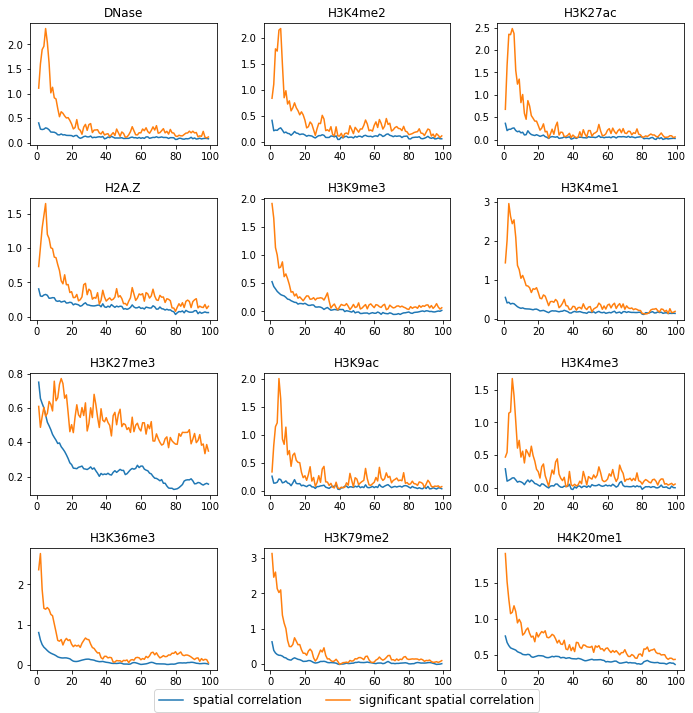

In [107]:
fig, axs = plt.subplots(4,3, figsize = (10,10))
for s, signal_name in enumerate(GM12878_signals_names):
    row_ind = int(s/3)
    col_ind = s%3
    sns.lineplot(x=np.arange(1,100), y=spatial_corrs[signal_name,10000][1:], 
                 label = 'spatial correlation', ax = axs[row_ind,col_ind])
    sns.lineplot(x=np.arange(1,100), y=significant_spatial_corrs[signal_name,10000][1:], 
                 label = 'significant spatial correlation', ax = axs[row_ind,col_ind])
    axs[row_ind,col_ind].set_title(signal_name, fontsize = 12)
    axs[row_ind,col_ind].get_legend().remove()
handles, labels = axs[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='right', prop={'size': 30})
fig.legend(handles, labels, loc="lower center", ncol=3, borderaxespad=0.1, fontsize = 12)
fig.tight_layout(pad=2.0)
fig.savefig('results/signals_spatial_corrs.png', dpi = 300,
            bbox_inches='tight',facecolor='white', transparent=False)

In [103]:
DNase_spatial_corrs = []
DNase_significant_spatial_corrs = []
DNase_weighted_spatial_corrs = []
for sh in np.arange(100):
    dmat = diag_mat(sizes[10000],sh)[np.ix_(valid_bins[10000],valid_bins[10000])]
    spatial_corr = evaluation_utils.spatial_correlation(signals[10000].iloc[:,0].values,dmat)['moran']
    dmat = diag_oe_mat(mats[10000], sizes[10000], sh, valid_bins[10000], 0)
    significant_spatial_corr = evaluation_utils.spatial_correlation(signals[10000].iloc[:,0].values,dmat)['moran']
    dmat = diag_oe_mat(mats[10000], sizes[10000], sh, valid_bins[10000], 1)
    weighted_spatial_corr = evaluation_utils.spatial_correlation(signals[10000].iloc[:,0].values,dmat)['moran']
    DNase_spatial_corrs.append(spatial_corr)
    DNase_significant_spatial_corrs.append(significant_spatial_corr)
    DNase_weighted_spatial_corrs.append(weighted_spatial_corr)

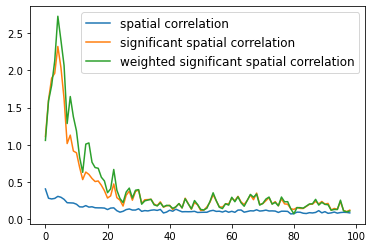

In [109]:
fig = plt.figure()
ax = sns.lineplot(x = np.arange(99), y = DNase_spatial_corrs[1:], 
             label = 'spatial correlation')
ax = sns.lineplot(x = np.arange(99), y = DNase_significant_spatial_corrs[1:], 
             label = 'significant spatial correlation')
ax = sns.lineplot(x = np.arange(99), y = DNase_weighted_spatial_corrs[1:],
            label = 'weighted significant spatial correlation')
plt.legend(loc="upper right", frameon=True, fontsize=12)
fig.savefig('results/DNase_corrs.png', dpi = 300,
            bbox_inches='tight',facecolor='white', transparent=False)

In [4]:
signals = {}
lengths = {}
for res in [10000, 25000, 100000]:
    signals_path = '../../data/GM12878/hg19/res{}_datasets/signals.txt'.format(res)
    signals[res] = np.loadtxt(signals_path)
    lengths[res] = datasets[res].get_chunks_lengths()

In [10]:
hmm_model = {}
for res in [10000,25000,100000]:
    hmm_model[res] = hmm.GaussianHMM(n_components=8, covariance_type = 'full', algorithm='viterbi')
    hmm_model[res].fit(signals[res], lengths[res])

<AxesSubplot:>

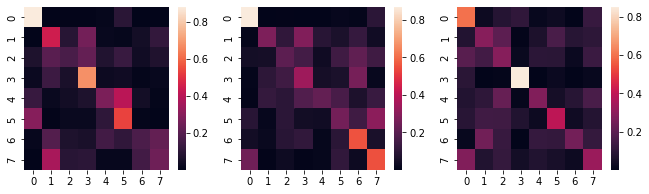

In [14]:
fig, axs = plt.subplots(1,3, figsize = (11,3))
sns.heatmap(hmm_model[10000].transmat_, ax = axs[0])
sns.heatmap(hmm_model[25000].transmat_, ax = axs[1])
sns.heatmap(hmm_model[100000].transmat_, ax = axs[2])

In [19]:
np.diag(hmm_model[100000].transmat_).mean()

0.4107744263281914